# Independent Project - Milestone 3

### Author - Ana Javed

Project Guidance and Instructions

Milestone 3 allows you to apply the knowledge you gained in Unit 3 of the course. In this milestone, you need to prepare the data for modeling as well as build an initial model that you will need to refine for Milestone 4..

For Milestone 3 you should

   - 1. prepare the data via cleaning, normalization, encoding, etc.
   - 2. generate and evaluate a working time series model.



In [252]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.graphics.tsaplots as splt
import statsmodels.tsa.seasonal as sts
import statsmodels.tsa.arima_process as arima

from statsmodels.tsa.stattools import adfuller
import sklearn.linear_model as lm
import pmdarima as pm
from pmdarima.arima import auto_arima

%matplotlib inline

## Data Source / Background Information:

According to the California Office of Environmental Health Hazard Assessment:(https://oehha.ca.gov/calenviroscreen/indicator/air-quality-pm25) 

"Particulate matter, or PM2.5, is very small particles in air that are 2.5 micrometers (about 1 ten-thousandth of an inch) or less in diameter. This is less than the thickness of a human hair. Particulate matter, one of six U.S. EPA criteria air pollutants, is a mixture that can include organic chemicals, dust, soot and metals. These particles can come from cars and trucks, factories, wood burning, and other activities."

PM2.5 can be examined to help measure the amount of pollution in the air. The dataset that will be analyzed is PM2.5 measurements collected by the US Embassy in Beijing. Details regarding the data can be found here: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data



In [253]:
## Data File URL 
fileName = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"

## Reading in the CSV filt into pandas data frame 
pollution_df = pd.read_csv(fileName)

## Top and Bottom 15 Rows 
print(pollution_df.head(15))
print("\n")
print(pollution_df.head(15))
print("\n")

## Exploratory Data Analysis 
print(pollution_df.columns) ## Printing Columns 
print("\n")
print(pollution_df.shape) ## Printing Data Dimensions 
print("\n")
print(pollution_df.dtypes) ## Printing Column Types 
print("\n")


    No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0    1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1    2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2    3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3    4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4    5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0
5    6  2010      1    1     5    NaN   -19 -10.0  1017.0   NW  16.10   0   0
6    7  2010      1    1     6    NaN   -19  -9.0  1017.0   NW  19.23   0   0
7    8  2010      1    1     7    NaN   -19  -9.0  1017.0   NW  21.02   0   0
8    9  2010      1    1     8    NaN   -19  -9.0  1017.0   NW  24.15   0   0
9   10  2010      1    1     9    NaN   -20  -8.0  1017.0   NW  27.28   0   0
10  11  2010      1    1    10    NaN   -19  -7.0  1017.0   NW  31.30   0   0
11  12  2010      1    1    11    NaN   -18  -5.0  1017.0   NW  

In [254]:
## Looking For Missing Values in the Columns. Want to Account for the NaN values! 
# pollution_df.loc[:, "pm2.5"].value_counts() # NaN values Present
# pollution_df.loc[:, "year"].value_counts() # none
# pollution_df.loc[:, "month"].value_counts() # none
# pollution_df.loc[:, "day"].value_counts() #none

## Identifying How Many NaNs in the pm2.5 column: 
HasNan1 = np.isnan(pollution_df.loc[:,'pm2.5'])
sum(HasNan1) # 2067 NaNs out of 43824
# pollution_df.loc[HasNan1,'pm2.5'] = np.nanmedian(pollution_df.loc[:,'pm2.5'])

# ## Dropping NaN Values 
pollution_df = pollution_df.dropna() 


## Confirming new Dimensions of the Data Frame: 
print(pollution_df.shape) # now 41757 Rows, 13 Columns 

(41757, 13)


In [255]:
## Scaling Temp, Pres, and Dew Point Columns 
# Declaring Scale function
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

pollution_df.loc[:, "DEWP"] = np.apply_along_axis(scale, 0, pollution_df.loc[:, "DEWP"])
pollution_df.loc[:, "TEMP"] = np.apply_along_axis(scale, 0, pollution_df.loc[:, "TEMP"])
pollution_df.loc[:, "PRES"] = np.apply_along_axis(scale, 0, pollution_df.loc[:, "PRES"])
# pollution_df.loc[:, "pm2.5"] = np.apply_along_axis(scale, 0, pollution_df.loc[:, "pm2.5"])

# print(pollution_df.head(15))
# print("\n")
# print(pollution_df.head(15))
# print("\n")


In [256]:
## Converting Year & Month Columns to Datetime Date Column in the Data Frame 
from datetime import datetime

pollution_df.loc[:, "Date"] = pd.to_datetime(pollution_df.loc[:, "year"].astype(str) + '-' + pollution_df.loc[:, "month"].astype(str)
                #                            + '-' + pollution_df.loc[:, "day"].astype(str) 
               # + ' ' + pollution_df.loc[:, "hour"].astype(str) + ":00"
                                            )
# New Combined Datetime Column: 
pollution_df.loc[:, "Date"]


## Taking average Of PM2.5 per Month 
pollution_df["avg_pm"] = pollution_df.groupby("Date")["pm2.5"].transform(np.average)

## Creating a new DF of the Monthly Dates & Average PM columns 
pm_df = pollution_df.loc[:, ["Date","avg_pm"]]
pm_df = pm_df.set_index("Date")

## Removing Duplicate Rows 
pm_df = pm_df.drop_duplicates()

## Examining the Shape / Format of the new DF: 
print(pm_df.shape) # (60, 1)
print(pm_df.head(10)) # Data Starts: 2010-01-01 
print(pm_df.tail(10)) # Data Ends: 2014-12-01  

(60, 1)
                avg_pm
Date                  
2010-01-01   90.442573
2010-02-01   97.233979
2010-03-01   94.100141
2010-04-01   80.029248
2010-05-01   86.899593
2010-06-01  109.003540
2010-07-01  123.647849
2010-08-01   97.602071
2010-09-01  122.510684
2010-10-01  118.982480
                avg_pm
Date                  
2014-03-01  110.485868
2014-04-01   95.232915
2014-05-01   72.254717
2014-06-01   59.082504
2014-07-01   89.455902
2014-08-01   62.942701
2014-09-01   70.293706
2014-10-01  140.555855
2014-11-01  104.378187
2014-12-01   78.648045


In [257]:
# One-hot encode inputs --> Month and Hour Columns Specifically
pollution_df = pd.get_dummies(pollution_df, columns=['month', 'hour'], drop_first=False,
                             )
print('DataFrame one-hot-expanded shape: {}'.format(pollution_df.shape))


DataFrame one-hot-expanded shape: (41757, 49)


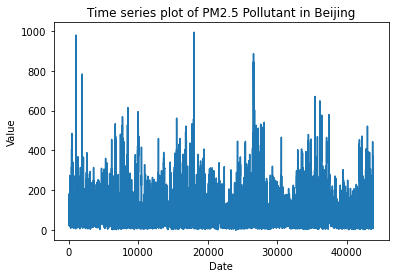

In [258]:
## Plotting the Time Series Plot of PM2.5 Pollutant 
def plot_ts(ts, lab = ''):
    ts.plot()
    plt.title('Time series plot of ' + lab)
    plt.ylabel('Value')
    plt.xlabel('Date')

## All Points Plotted from Original Dataset
plot_ts(pollution_df.loc[:, "pm2.5"], 'PM2.5 Pollutant in Beijing')

There are a lot of data points in this time series. I am going to rely on using only the montly averages of the data for the decomposition (below) which is much more readable and cleaner. 

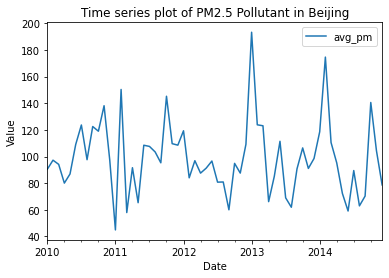

In [259]:
## All Points Plotted from Original Dataset
plot_ts(pm_df, 'PM2.5 Pollutant in Beijing')

#### Time Series Plot Analysis

The time series plot has a slightly consistent trend over the years, and there does appear to be a seasonal component to the data. However we see that there are larger increases in 2013 and 2014 - and pm2.5 levels get above 160. 

Since there is not an overall upward trend over time, I will use an additive decomposition model.

This time series is not stationary since the variance does appear to vary over time. 

In [260]:
## Defining Decomposition Function 
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model)
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                       index = ts.index) )

                resid       trend   seasonal
Date                                        
2010-01-01        NaN         NaN  18.103806
2010-02-01        NaN         NaN  32.997216
2010-03-01        NaN         NaN  -2.200742
2010-04-01        NaN         NaN -13.850333
2010-05-01        NaN         NaN -20.340705
2010-06-01        NaN         NaN  -4.399669
2010-07-01  25.691465  102.760864  -4.804480
2010-08-01   9.718876  103.074874 -15.191679
2010-09-01  28.716605  103.779279  -9.985200
2010-10-01   2.302610  102.753230  13.926639
2010-11-01  31.649327  102.335672   4.135483
2010-12-01  -5.690564  101.414233   1.609665
2011-01-01 -73.934493  100.722056  18.103806
2011-02-01  17.029372  100.294841  32.997216
2011-03-01 -39.283382   99.402525  -2.200742
2011-04-01   6.075084   99.361070 -13.850333
2011-05-01 -13.605188   99.267522 -20.340705
2011-06-01  14.320018   98.546600  -4.399669
2011-07-01  10.263193  102.113486  -4.804480
2011-08-01  16.165473  102.450767 -15.191679
2011-09-01

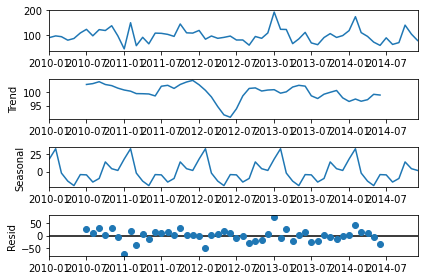

In [261]:
## Applying the Decomposition function to the FULL PM2.5 Dataset: 
pm_decomp = decomp_ts(pm_df)

print(pm_decomp)


The decomposition results of the monthly averaged data looks appropriate. I see that the seasonal trend is much more discernable and clear enough to read! It is also regularly occuring between 25 and -25. 

The trend plot does have irregular peaks throughout the month, as some peaks are larger than others. There's also a large decrease in the trend around mid-2012.

It is also important to note that the residual and trend columns have NaN values in the first and last 6 rows of the data frame since it's a monthly time series. We will separate these out when applying the Dicky Fuller test. 


In [262]:
## Conducting the Dicky Fuller Test

# Declaring the Function 
def DF_Test(ts):
    stationary = adfuller(ts)
    ## Print the results
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%']))
    
## Applying the Test to the decomposition residuals 
DF_Test(pm_decomp.resid[6:-6])    

D-F statistic = -4.828646859513702
p-value = 4.792334401887742e-05
number of lags used = 3
Critical value at 5% confidence = -2.929885661157025
Critical value at 10% confidence = -2.6031845661157025


Given that there is a large DF statistic and that the p-value is small (< 0.05), we can reject the null hypothesis that the residual is not stationary. We also know that this is not due to random chance since that confidence interval does not straddle 0.

### Using the auto_arima function from the pmdarima package to find a best model fit, excluding the last 12 months of observations from the training data, and setting d=1 and D=1 and limit p, q, P and Q to 3 with starting values of 1.

In [263]:
import pmdarima as pm
from pmdarima.arima import auto_arima

## Applying the Auto_arima function
stepwise_fit = auto_arima(pm_df.avg_pm, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # ignoring if an order does not work
                             suppress_warnings=True,  # removing convergence warnings
                             stepwise=True)  # set to stepwise

## Printing Summary & Best AIC value
print(stepwise_fit.summary())

print("Best AIC Value: ", stepwise_fit.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=505.978, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=482.943, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=484.298, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=470.819, Time=0.32 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=472.285, Time=0.80 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=481.906, Time=0.30 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=471.309, Time=0.47 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=472.374, Time=0.73 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]          
Total fit

### Summary Review

Using the AIC value to find the best model, we see that the best model suggested by the Auto_arima function is the  ARIMA(1,1,0)(2,1,0)[12] which has an AIC value of 472.374.

All of the model coeffients are statistically significant, since the p-values are less than 0.05 and the confidence intervals do not contain zero (aside from sigma2).


In [264]:
## Splitting Test and Training Data 
train = pm_df[:-12]  ## Training on the First 7 Weeks of the MOnth 
test = pm_df[-12:] ## Testting on the Final Week of the MOnth 


print(train) # 2010 - 2013 Data Values
print(test) # 2014 Year Data Values

                avg_pm
Date                  
2010-01-01   90.442573
2010-02-01   97.233979
2010-03-01   94.100141
2010-04-01   80.029248
2010-05-01   86.899593
2010-06-01  109.003540
2010-07-01  123.647849
2010-08-01   97.602071
2010-09-01  122.510684
2010-10-01  118.982480
2010-11-01  138.120482
2010-12-01   97.333333
2011-01-01   44.891369
2011-02-01  150.321429
2011-03-01   57.918400
2011-04-01   91.585821
2011-05-01   65.321629
2011-06-01  108.466948
2011-07-01  107.572200
2011-08-01  103.424561
2011-09-01   95.272601
2011-10-01  145.225649
2011-11-01  109.632168
2011-12-01  108.519515
2012-01-01  119.310448
2012-02-01   83.997101
2012-03-01   96.856757
2012-04-01   87.518776
2012-05-01   91.280753
2012-06-01   96.596045
2012-07-01   80.748547
2012-08-01   80.865169
2012-09-01   60.001401
2012-10-01   94.839189
2012-11-01   87.555874
2012-12-01  109.197068
2013-01-01  193.273342
2013-02-01  123.801788
2013-03-01  123.064953
2013-04-01   66.113287
2013-05-01   85.125172
2013-06-01 

In [265]:
## Fitting the Model with the Training Dataset 
stepwise_fit.fit(train)

## Using the Model to predict the values of the Test Dataset
predictions, CI = stepwise_fit.predict(n_periods=test.shape[0], return_conf_int = True)



In [266]:
print(predictions)
print(test)

[ 96.12379378 140.62624184  73.54818626  68.2074868   59.57791337
 101.76539059  80.6562863   74.25085759  88.89377383 123.12169324
  92.88513823  91.92085105]
                avg_pm
Date                  
2014-01-01  118.557666
2014-02-01  174.617339
2014-03-01  110.485868
2014-04-01   95.232915
2014-05-01   72.254717
2014-06-01   59.082504
2014-07-01   89.455902
2014-08-01   62.942701
2014-09-01   70.293706
2014-10-01  140.555855
2014-11-01  104.378187
2014-12-01   78.648045


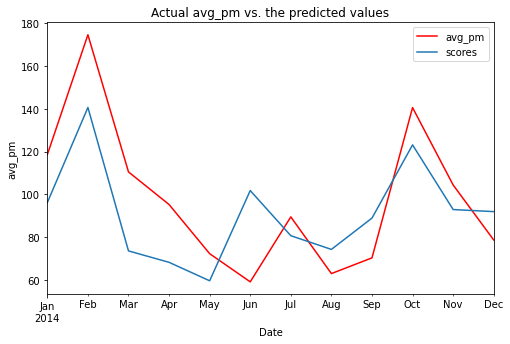

In [267]:
def plot_mod_fit(df, col):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8, 5)) # set plot area
    ax = fig.gca() # define axis  
    df.loc[:, col].plot(color = 'r', ax = ax)
    df.loc[:, 'scores'].plot(ax = ax) 
    ax.set_title('Actual ' + col + ' vs. the predicted values') # Give the plot a main title
    ax.set_xlabel('Date') # Set text for the x axis
    ax.set_ylabel(col)# Set text for y axis
    ax.legend()
    
## Adding the Scores Column 
predictions = pd.DataFrame(predictions, index = test.index,
                               columns=['scores'])
predictions = pd.concat([test, predictions],axis=1)

## Adding a Residual Column 
predictions.loc[:, "residual"] = predictions.loc[:, "scores"] - predictions.loc[:, "avg_pm"]


## Plotting Prediction vs Actual Values 
plot_mod_fit(predictions, 'avg_pm')

These predictions are close to the actual observations. The two lines in the plot above do not overlap on some parts (March to November, for example) however the difference between the values are not drastically different. The best way to check how close the actual observations are to the predictions is relying on the RMSE.

In [268]:
def RMSE(ts, score):
    from math import sqrt
    return sqrt(np.std(ts - score))

RMSE(predictions.loc[:, "avg_pm"], predictions.loc[:, "scores"])

4.786433346868144

A root mean square error (RMSE) of the fit of the model for the last 12 months in the data of milk production is 4.786. This is not terribly high considering the relative values of the forecast range from 60 to 180. 

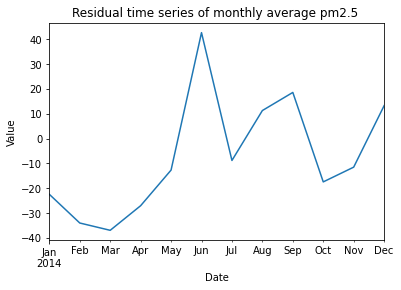

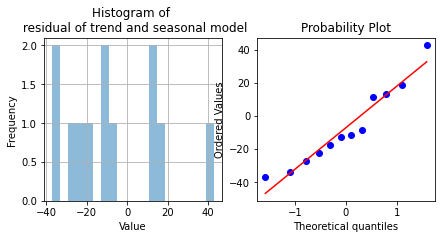

In [269]:
def dist_ts(ts, lab = '', bins = 20):
    import scipy.stats as ss
    ## Setup a figure with two subplots side by side
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ## Plot the histogram with labels
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of ' + lab)
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax2)
    
def plot_ts(ts, title):
    ts.plot()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    
    
    
plot_ts(predictions.loc[:, 'residual'],  
        title = 'Residual time series of monthly average pm2.5 ' )

dist_ts(predictions.loc[:, 'residual'], 
        '\n residual of trend and seasonal model')

The time series of the residual doesn't really show any periodic behaivor. The histogram of the residual data does not appear to be normally distributed, however the probability plot does appear to fall some what close to the red line.


In [270]:
print("Confidence Intervals for the Predictions in 2013: ")
print(CI)

print("\n")

print("Mean for the Forecast/Predictions: ")
print(np.mean(predictions))

Confidence Intervals for the Predictions in 2013: 
[[ 38.79572641 153.45186116]
 [ 78.00756019 203.2449235 ]
 [ -2.53003482 149.62640735]
 [-14.76236461 151.17733821]
 [-32.00270703 151.15853378]
 [  3.51051051 200.02027067]
 [-24.46673711 185.77930971]
 [-36.98819178 185.48990696]
 [-28.31710118 206.10464884]
 [  0.32267524 245.92071125]
 [-35.3088849  221.07916135]
 [-41.4229816  225.26468371]]


Mean for the Forecast/Predictions: 
avg_pm      98.042117
scores      90.964801
residual    -7.077316
dtype: float64


The confidence interval ranges fluctuate a lot and can be large at times. 